In [2]:
import os
import sys
import logging
# import glob
# import time
# import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import root_scalar, minimize
from scipy.special  import erf, erfc

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Custom packages
import iXAtom_Class_Physics       as iXC_Physics
import iXAtom_Class_RunParameters as iXC_RunPars
import iXAtom_Class_Detector      as iXC_Detect
import iXAtom_Class_Ramsey        as iXC_Ramsey
import iXAtom_Utilities           as iXUtils

# For inline plots
%matplotlib inline
# Reload IPython extension 'autoreload'
%reload_ext autoreload
# autoreload: Reload all modules (except those excluded by %aimport) automatically now
# autoreload 0: Disable automatic reloading of modules
# autoreload 1: Reload all modules imported with %aimport every time before executing
# autoreload 2: Reload all modules (except those excluded by %aimport) every time before executing
%autoreload 1

%aimport iXAtom_Class_Physics
%aimport iXAtom_Class_RunParameters
%aimport iXAtom_Class_Detector
%aimport iXAtom_Class_Ramsey
%aimport iXAtom_Utilities

logging.disable(level=logging.NOTSET)

iXUtils.SetDefaultPlotOptions()

In [3]:
RootDir = 'C:\\Bryns Goodies\\Work-iXAtom\\Data 2020'
Date    = {'Month': 'July', 'Day': 1}
WorkDir = os.path.join(RootDir, Date['Month'], '{:02d}'.format(Date['Day']))
Folder  = 'Ramsey'
RunNum  = 1

RunPars = iXC_RunPars.RunParameters(WorkDir, Folder, RunNum)
RunPars.LoadRunParameters()

Physics = iXC_Physics.Physics(RunPars)
keff    = RunPars.keff
gLocal  = RunPars.gLocal
iaxList = RunPars.iaxList
ikList  = RunPars.ikList
omegaR  = RunPars.omegaR
fR      = omegaR/(2.*np.pi*1.E3)

pd.DataFrame(RunPars.__dict__.items())

,0,1
0,SoftwareVersion,3.3
1,Run,1
2,DataType,Ramsey
3,TrackProtocol,Two-Point kInterlaced
4,TrackMode,"Open Loop, Fixed Chirp"
...,...,...
101,nk,1
102,nax,1
103,FilePrefix,Ramsey
104,AxisFileLabels,"[X, Y, Z]"


In [4]:
def dG(x, n, TOF, t, tD, rD, sigR, sigV):
    """Derivative of detector response in velocity space"""
    g   = 9.805642E-3 ## mm/ms^2
    vR  = 1.17E-2     ## mm/ms
    sig = np.sqrt(sigR**2 + (sigV*t)**2)
    dz  = n*vR*(t - TOF) + 0.5*g*(t**2 - tD**2)
    a   = (x*t + dz)*sig/(sigR*sigV*t)
    b   = rD*sigV*t/(sig*sigR)
    c   = rD/sigR
    d   = (x*t + dz)/sigR
    A   = np.exp(-rD**2/sig**2 + (2*x*t*dz + dz**2)/(sigV*t)**2)
    B   = np.exp(-x**2/sigV**2)
    
    def erf2(x, y):
        """Two-argument generalized Error function. Avoids catastrophic cancellation when x, y become large."""
        if (x <= 0. and y >= 0.) or (y <= 0. and x >= 0.):
            return erf(y) - erf(x)
        elif x >= 0. and y >= 0.:
            return erfc(x) - erfc(y)
        elif x <= 0. and y <= 0.:
            return erfc(-y) - erfc(-x)
    
    dG1 = sig**2/(np.sqrt(np.pi)*sigR*sigV**2*t) * A*(np.exp(-(a-b)**2) - np.exp(-(a+b)**2))
    dG2 = dz*sig/(sigV**3*t**2) * A*erf2(a+b, a-b)
    dG3 = t/(np.sqrt(np.pi)*sigR) * B*(np.exp(-(c+d)**2) - np.exp(-(c-d)**2))
    dG4 = -x/sigV**2 * B*(erf(c-d) + erf(c+d))
    
    return dG1 + dG2 + dG3 + dG4

def DetectionShifts(TOF, t, tD, rD, sigR, sigV):
    """Compute velocity shifts (mm/ms = m/s) from the root of dG(v)"""
    vShift_kU = root_scalar(dG, args=(+1, TOF, t, tD, rD, sigR, sigV), bracket=[-0.1, 0.1], method='brentq').root
    vShift_kD = root_scalar(dG, args=(-1, TOF, t, tD, rD, sigR, sigV), bracket=[-0.1, 0.1], method='brentq').root
    
    keff      = 1.6105744E7/(2.*np.pi) ## 1/m
    delta_kU  =  keff*vShift_kU*1.E-3
    delta_kD  = -keff*vShift_kD*1.E-3

    Sigma     = 0.5*(delta_kU + delta_kD)
    Delta     = 0.5*(delta_kU - delta_kD)
    
    return (vShift_kU, vShift_kD, delta_kU, delta_kD, Sigma, Delta)

def DetectionWidths(TOF, t, tD, rD, sigR, sigV, vShift_kU, vShift_kD):
    """Compute velocity widths (mm/ms = m/s) from the minimum of dG(v)"""
    vWidth_kU = 2.*abs(minimize(dG, x0=sigV, args=(+1, TOF, t, tD, rD, sigR, sigV), method='Nelder-Mead', tol=1.E-7).x[0] - vShift_kU)
    vWidth_kD = 2.*abs(minimize(dG, x0=sigV, args=(-1, TOF, t, tD, rD, sigR, sigV), method='Nelder-Mead', tol=1.E-7).x[0] - vShift_kD)
    
    keff      = 1.6105744E7/(2.*np.pi) ## 1/m
    sigma_kU  = keff*vWidth_kU*1.E-3
    sigma_kD  = keff*vWidth_kD*1.E-3

    Sigma     = 0.5*(sigma_kU + sigma_kD)
    Delta     = 0.5*(sigma_kU - sigma_kD)
        
    return (vWidth_kU, vWidth_kD, sigma_kU, sigma_kD, Sigma, Delta)

In [5]:
#========================================================================================= 
#  Load analysis summary results for specific runs on specific days
#=========================================================================================

# DateList = [{'Month': 'July', 'Day': 1}, {'Month': 'July', 'Day': 1}, {'Month': 'July', 'Day': 2},
#             {'Month': 'July', 'Day': 27}, {'Month': 'July', 'Day': 27}, {'Month': 'July', 'Day': 27}]
# RunLists = [[19,23], [24,28], [1,5], [17,24], [25,32], [33,40]]
# RamanTOF = np.array([0.016, 0.046, 0.076, 0.077, 0.047, 0.017]) ## ms
# Colors   = ['red', 'blue', 'green', 'purple', 'darkorange', 'deeppink']
# nSummary = len(RunLists)

DateList = [{'Month': 'July', 'Day': 1}, {'Month': 'July', 'Day': 1}, {'Month': 'July', 'Day': 1},
            {'Month': 'July', 'Day': 27}, {'Month': 'July', 'Day': 27}, {'Month': 'July', 'Day': 27}]
RunLists = [[1,3], [4,6], [7,9], [17,24], [25,32], [33,40]]
RamanTOF = np.array([0.076, 0.046, 0.016, 0.077, 0.047, 0.017]) ## ms
Colors   = ['red', 'blue', 'green', 'purple', 'darkorange', 'deeppink']
nSummary = len(RunLists)

SummaryDF = [[[pd.DataFrame([]) for ik in range(2)] for iax in range(3)] for s in range(nSummary)]

for s in range(nSummary):
    RunList = RunLists[s]
    WorkDir = os.path.join(RootDir, DateList[s]['Month'], '{:02d}'.format(DateList[s]['Day']))
    RunPars = iXC_RunPars.RunParameters(WorkDir, Folder, RunList[0])
    RunPars.LoadRunParameters()

    SummaryFolder     = os.path.join(WorkDir, 'PostProcessed', Folder)
    SummaryFilePrefix = Folder+'-Runs{:02d}-{:02d}-AnalysisSummary-'.format(min(RunList), max(RunList))

    for iax in iaxList:
        for ik in ikList:
            SummaryFilePath = os.path.join(SummaryFolder, SummaryFilePrefix+RunPars.AxisFileLabels[iax][ik]+'.txt')
            if os.path.exists(SummaryFilePath):
                print('Loading summary file: {}'.format(SummaryFilePath))
                SummaryDF[s][iax][ik] = pd.read_csv(SummaryFilePath, sep='\t')                
#                 if DateList[s]['Day'] == 13 and RunLists[s] == [76,105]:
#                     print('Dropping elements from summary...')
#                     SummaryDF[s][iax][ik].drop([8], inplace=True)
#                 SummaryDF[s][iax][ik].sort_values(by=['RamanT'], inplace=True)
            else:
                print('Summary file not found: {}'.format(SummaryFilePath))

Summary file not found: C:\Bryns Goodies\Work-iXAtom\Data 2020\July\01\PostProcessed\Ramsey\Ramsey-Runs01-03-AnalysisSummary-Z.txt
Summary file not found: C:\Bryns Goodies\Work-iXAtom\Data 2020\July\01\PostProcessed\Ramsey\Ramsey-Runs04-06-AnalysisSummary-Z.txt
Summary file not found: C:\Bryns Goodies\Work-iXAtom\Data 2020\July\01\PostProcessed\Ramsey\Ramsey-Runs07-09-AnalysisSummary-Z.txt
Summary file not found: C:\Bryns Goodies\Work-iXAtom\Data 2020\July\27\PostProcessed\Ramsey\Ramsey-Runs17-24-AnalysisSummary-Z.txt
Summary file not found: C:\Bryns Goodies\Work-iXAtom\Data 2020\July\27\PostProcessed\Ramsey\Ramsey-Runs25-32-AnalysisSummary-Z.txt
Summary file not found: C:\Bryns Goodies\Work-iXAtom\Data 2020\July\27\PostProcessed\Ramsey\Ramsey-Runs33-40-AnalysisSummary-Z.txt


In [35]:
## Merge data from other days with certain SummaryDF

DateList2 = [{'Month': 'July', 'Day': 2}, {'Month': 'July', 'Day': 2}, {'Month': 'July', 'Day': 2}]
RunLists2 = [[10,11], [8,9], [6,7]]
nSummary2 = len(RunLists2)

s = -1
for ss in range(nSummary2):
    s += 1
    RunList  = RunLists[s]
    RunList2 = RunLists2[ss]
    WorkDir  = os.path.join(RootDir, DateList[s]['Month'], '{:02d}'.format(DateList[s]['Day']))
    WorkDir2 = os.path.join(RootDir, DateList2[ss]['Month'], '{:02d}'.format(DateList2[ss]['Day']))
    RunPars  = iXC_RunPars.RunParameters(WorkDir2, Folder, RunList2[0])
    RunPars.LoadRunParameters()

    SummaryFolder      = os.path.join(WorkDir, 'PostProcessed', Folder)
    SummaryFilePrefix  = Folder+'-Runs{:02d}-{:02d}-AnalysisSummary-'.format(min(RunList), max(RunList))
    SummaryFolder2     = os.path.join(WorkDir2, 'PostProcessed', Folder)
    SummaryFilePrefix2 = Folder+'-Runs{:02d}-{:02d}-AnalysisSummary-'.format(min(RunList2), max(RunList2))

    for iax in iaxList:
        for ik in ikList:
            SummaryFilePath  = os.path.join(SummaryFolder, SummaryFilePrefix+RunPars.AxisFileLabels[iax][ik]+'.txt')
            SummaryFilePath2 = os.path.join(SummaryFolder2, SummaryFilePrefix2+RunPars.AxisFileLabels[iax][ik]+'.txt')
            if os.path.exists(SummaryFilePath2):
                print('Loading      summary file: {}'.format(SummaryFilePath2))
                df = pd.read_csv(SummaryFilePath2, sep='\t')
                print('Merging with summary file: {}'.format(SummaryFilePath))
                SummaryDF[s][iax][ik] = SummaryDF[s][iax][ik].merge(df, how='outer')
            else:
                print('Summary file not found: {}'.format(SummaryFilePath2))

Loading      summary file: C:\Bryns Goodies\Work-iXAtom\Data 2020\July\02\PostProcessed\Ramsey\Ramsey-Runs10-11-AnalysisSummary-Z.txt
Merging with summary file: C:\Bryns Goodies\Work-iXAtom\Data 2020\July\01\PostProcessed\Ramsey\Ramsey-Runs01-03-AnalysisSummary-Z.txt
Loading      summary file: C:\Bryns Goodies\Work-iXAtom\Data 2020\July\02\PostProcessed\Ramsey\Ramsey-Runs08-09-AnalysisSummary-Z.txt
Merging with summary file: C:\Bryns Goodies\Work-iXAtom\Data 2020\July\01\PostProcessed\Ramsey\Ramsey-Runs04-06-AnalysisSummary-Z.txt
Loading      summary file: C:\Bryns Goodies\Work-iXAtom\Data 2020\July\02\PostProcessed\Ramsey\Ramsey-Runs06-07-AnalysisSummary-Z.txt
Merging with summary file: C:\Bryns Goodies\Work-iXAtom\Data 2020\July\01\PostProcessed\Ramsey\Ramsey-Runs07-09-AnalysisSummary-Z.txt


In [6]:
SummaryDF[0][iax][ik]

""


In [7]:
## Set plot options
plt.rc('font', size=16, family='serif')
plt.rc('axes', titlesize=12, labelsize=16, edgecolor='black', linewidth=1)
plt.rc('lines', linewidth=2.5, markersize=14)
plt.rc('legend', fontsize=16, frameon=False, handletextpad=0.4)

PlotOpts = {'Color': 'red', 'Linestyle': 'None', 'Marker': '.', 'Title': 'None',
            'xLabel': 'None', 'yLabel': 'None', 'LegLabel': 'None', 'Legend': False,
            'LegLocation': 'best'}

xLabel   = 'Detect TOF  (ms)'
yLabels  = [[r'$\delta_{\!\!\uparrow}$  (kHz)', r'$\delta_{\!\!\downarrow}$  (kHz)'],
            [r'$\Sigma\delta$  (kHz)', r'$\Delta\delta$  (kHz)'],
            [r'$\delta_{\!\!\uparrow} (-\delta_{\!\!\downarrow})$  (kHz)', r'$\delta_{\!\!\uparrow} (-\delta_{\!\!\downarrow})$  (kHz)']]
lLabels  = ['{:.1f}  ms'.format(RamanTOF[s]*1.E3) for s in range(nSummary)]

(nRows, nCols) = (2,3)
fig, axs = plt.subplots(nrows=nRows, ncols=nCols, figsize=(nCols*6,nRows*4), sharex='col', constrained_layout=True)

fk  = np.empty((2,2), dtype=object) ## [ik, iErr]
iax = iaxList[0]
ik  = ikList[0]
v0  = 0.
# v0  = 0.0105
# v0  = 0.019
        
for s in range(nSummary):

    PlotOpts['Color'] = Colors[s]

    if DateList[s] == {'Month': 'July', 'Day': 27}:
        DetectTOF = SummaryDF[s][iax][ik]['DetectTOF'].to_numpy() + 0.001 ## Correct timing by 1 ms
    else:
        DetectTOF = SummaryDF[s][iax][ik]['DetectTOF'].to_numpy()
 
    fD = keff*(v0 + gLocal*RamanTOF[s])*np.ones(len(DetectTOF))/(2.*np.pi*1.E3) ## kHz

    fk[0,0] = SummaryDF[s][iax][ik]['p08_center'].to_numpy()
    fk[0,1] = SummaryDF[s][iax][ik]['p08_center_Err'].to_numpy()
    fk[1,0] = SummaryDF[s][iax][ik]['p02_center'].to_numpy()
    fk[1,1] = SummaryDF[s][iax][ik]['p02_center_Err'].to_numpy()

    PlotOpts['xLabel'] = 'None'
    PlotOpts['yLabel'] = yLabels[0][0]
    iXUtils.CustomPlot(axs[0,0], PlotOpts, DetectTOF*1.E3, fk[0,0] - fD - fR, fk[0,1])

    PlotOpts['yLabel'] = yLabels[1][0]
    iXUtils.CustomPlot(axs[0,1], PlotOpts, DetectTOF*1.E3, 0.5*(fk[0,0] + fk[1,0]) - fR, 0.5*np.sqrt(fk[0,1]**2 + fk[1,1]**2))
    
    PlotOpts['xLabel'] = xLabel
    PlotOpts['yLabel'] = yLabels[0][1]
    iXUtils.CustomPlot(axs[1,0], PlotOpts, DetectTOF*1.E3, fk[1,0] + fD - fR, fk[1,1])

    PlotOpts['yLabel'] = yLabels[1][1]
    iXUtils.CustomPlot(axs[1,1], PlotOpts, DetectTOF*1.E3, 0.5*(fk[0,0] - fk[1,0]) - fD, 0.5*np.sqrt(fk[0,1]**2 + fk[1,1]**2))

    if DateList[s] == {'Month': 'July', 'Day': 1} or DateList[s] == {'Month': 'July', 'Day': 2}:
        PlotOpts['xLabel']   = 'None'
        PlotOpts['yLabel']   = yLabels[2][0]
        PlotOpts['LegLabel'] = lLabels[s]
        iXUtils.CustomPlot(axs[0,2], PlotOpts, DetectTOF*1.E3,  fk[0,0] - fD - fR, fk[0,1])
        PlotOpts['LegLabel'] = None
        iXUtils.CustomPlot(axs[0,2], PlotOpts, DetectTOF*1.E3, -fk[1,0] - fD + fR, fk[1,1])
    else:
        PlotOpts['xLabel']   = xLabel
        PlotOpts['yLabel']   = yLabels[2][1]
        PlotOpts['LegLabel'] = lLabels[s]
        iXUtils.CustomPlot(axs[1,2], PlotOpts, DetectTOF*1.E3,  fk[0,0] - fD - fR, fk[0,1])
        PlotOpts['LegLabel'] = None
        iXUtils.CustomPlot(axs[1,2], PlotOpts, DetectTOF*1.E3, -fk[1,0] - fD + fR, fk[1,1])

tD    = 87.
TOF   = RamanTOF*1.E3
rD    = [4.60, 4.60, 4.60, 6.47, 6.47, 6.47]
sigR  = [2.55, 2.55, 2.55, 2.66, 2.66, 2.66]
sigV  = 0.022

tList = np.linspace(78,94,num=51)
nt    = len(tList)
delta = np.zeros((4,nt))
fDop  = [27.,27.,27.,48.,48.,48.]
fLS   = [2.,2.,2.,2.,2.,2.]

PlotOpts['Linestyle'] = '-'
PlotOpts['Marker']    = 'None'

for j in range(len(TOF)):
    for i in range(nt):
        delta[:,i] = DetectionShifts(TOF[j], tList[i], tD, rD[j], sigR[j], sigV)[2:]

    PlotOpts['Color']  = Colors[j]
    PlotOpts['xLabel'] = 'None'
    PlotOpts['yLabel'] = yLabels[1][0]
    iXUtils.CustomPlot(axs[0,1], PlotOpts, tList, delta[2] + fLS[j])

    PlotOpts['Color']  = Colors[j]
    PlotOpts['xLabel'] = xLabel
    PlotOpts['yLabel'] = yLabels[1][1]
    iXUtils.CustomPlot(axs[1,1], PlotOpts, tList, delta[3] + fDop[j])

axs[0,2].legend(loc='upper left', bbox_to_anchor=(1.005,1.0))
axs[1,2].legend(loc='upper left', bbox_to_anchor=(1.005,1.0))

plt.show()

KeyError: 'DetectTOF'

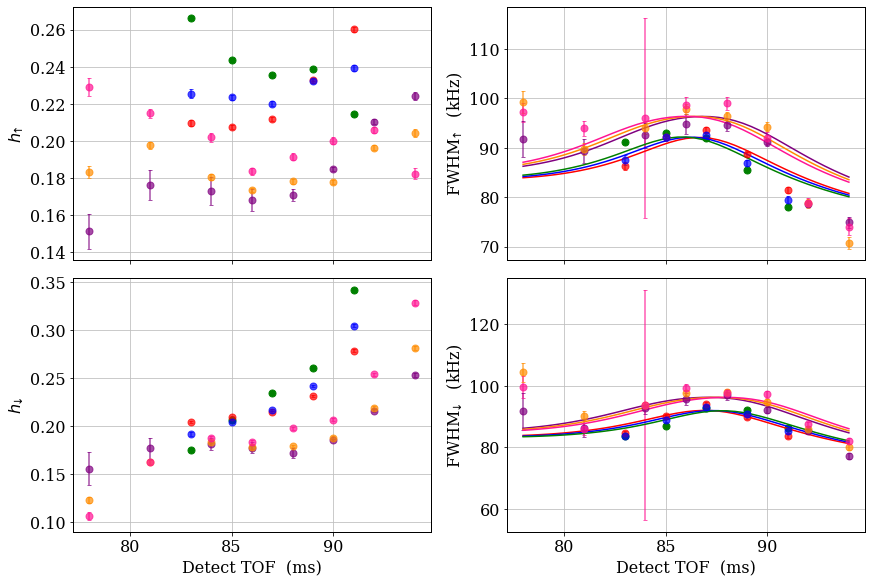

In [59]:
## Set plot options
plt.rc('font', size=16, family='serif')
plt.rc('axes', titlesize=12, labelsize=16, edgecolor='black', linewidth=1)
plt.rc('lines', linewidth=1.5, markersize=14)
plt.rc('legend', fontsize=16, frameon=False, handletextpad=0.4)

PlotOpts = {'Color': 'red', 'Linestyle': 'None', 'Marker': '.', 'Title': 'None',
            'xLabel': 'None', 'yLabel': 'None', 'LegLabel': 'None', 'Legend': False,
            'LegLocation': 'best'}

xLabel   = 'Detect TOF  (ms)'
yLabels  = [[r'$h_{\!\!\uparrow}$', r'$h_{\!\!\downarrow}$'], [r'FWHM$_{\!\!\uparrow}$  (kHz)', r'FWHM$_{\!\!\downarrow}$  (kHz)']]
lLabels  = ['{:.1f}  ms'.format(RamanTOF[s]*1.E3) for s in range(nSummary)]

(nRows, nCols) = (2,2)
fig, axs = plt.subplots(nrows=nRows, ncols=nCols, figsize=(nCols*6,nRows*4), sharex='col', constrained_layout=True)

hk  = np.empty((2,2), dtype=object)
wk  = np.empty((2,2), dtype=object)
iax = iaxList[0]
ik  = ikList[0]

for s in range(nSummary):

    PlotOpts['Color'] = Colors[s]    
    if DateList[s] == {'Month': 'July', 'Day': 27}:
        DetectTOF = SummaryDF[s][iax][ik]['DetectTOF'].to_numpy() + 0.001 ## Correct timing by 1 ms
    else:
        DetectTOF = SummaryDF[s][iax][ik]['DetectTOF'].to_numpy()
        
    hk[0,0] = SummaryDF[s][iax][ik]['p08_height'].to_numpy()
    hk[0,1] = SummaryDF[s][iax][ik]['p08_height_Err'].to_numpy()
    hk[1,0] = SummaryDF[s][iax][ik]['p02_height'].to_numpy()
    hk[1,1] = SummaryDF[s][iax][ik]['p02_height_Err'].to_numpy()

    wk[0,0] = SummaryDF[s][iax][ik]['p08_fwhm'].to_numpy()
    wk[0,1] = SummaryDF[s][iax][ik]['p08_fwhm_Err'].to_numpy()
    wk[1,0] = SummaryDF[s][iax][ik]['p02_fwhm'].to_numpy()
    wk[1,1] = SummaryDF[s][iax][ik]['p02_fwhm_Err'].to_numpy()

    PlotOpts['xLabel'] = 'None'
    PlotOpts['yLabel'] = yLabels[0][0]
    iXUtils.CustomPlot(axs[0,0], PlotOpts, DetectTOF*1.E3, hk[0,0], hk[0,1])

    PlotOpts['yLabel'] = yLabels[1][0]
    iXUtils.CustomPlot(axs[0,1], PlotOpts, DetectTOF*1.E3, wk[0,0], wk[0,1])
    
    PlotOpts['xLabel'] = xLabel
    PlotOpts['yLabel'] = yLabels[0][1]
    iXUtils.CustomPlot(axs[1,0], PlotOpts, DetectTOF*1.E3, hk[1,0], hk[1,1])

    PlotOpts['yLabel'] = yLabels[1][1]
    iXUtils.CustomPlot(axs[1,1], PlotOpts, DetectTOF*1.E3, wk[1,0], wk[1,1])

tD    = 87.
TOF   = RamanTOF*1.E3
rD    = [4.60, 4.60, 4.60, 6.47, 6.47, 6.47]
sigR  = [2.55, 2.55, 2.55, 2.66, 2.66, 2.66]
sigV  = 0.022

tList = np.linspace(78,94,num=41)
nt    = len(tList)
sigma = np.zeros((4,nt))

PlotOpts['Linestyle'] = '-'
PlotOpts['Marker']    = 'None'

for j in range(len(TOF)):
    for i in range(nt):
        vshift = DetectionShifts(TOF[j], tList[i], tD, rD[j], sigR[j], sigV)[:2]
        sigma[:,i] = DetectionWidths(TOF[j], tList[i], tD, rD[j], sigR[j], sigV, vshift[0], vshift[1])[2:]

    PlotOpts['Color']  = Colors[j]
    PlotOpts['xLabel'] = 'None'
    PlotOpts['yLabel'] = yLabels[1][0]
    iXUtils.CustomPlot(axs[0,1], PlotOpts, tList, 1.22*sigma[0])

    PlotOpts['Color']  = Colors[j]
    PlotOpts['xLabel'] = xLabel
    PlotOpts['yLabel'] = yLabels[1][1]
    iXUtils.CustomPlot(axs[1,1], PlotOpts, tList, 1.22*sigma[1])

plt.show()

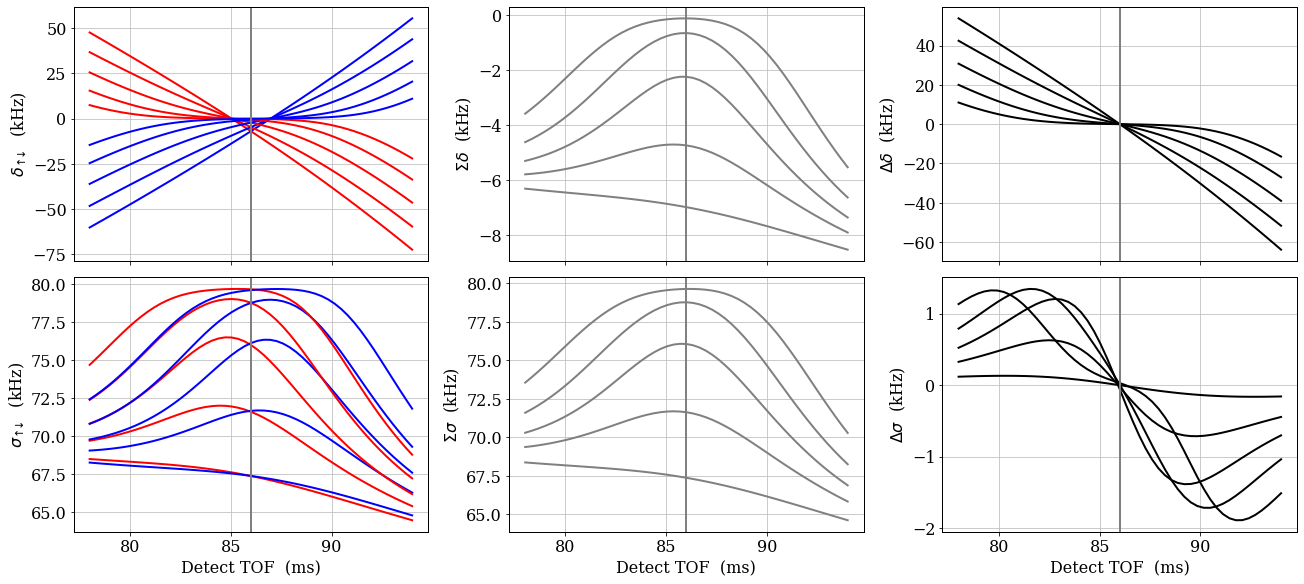

In [8]:
## Set plot options
plt.rc('font', size=16, family='serif')
plt.rc('axes', titlesize=12, labelsize=16, edgecolor='black', linewidth=1)
plt.rc('lines', linewidth=2.0, markersize=14)
plt.rc('legend', fontsize=16, frameon=False, handletextpad=0.4)

PlotOpts = {'Color': 'red', 'Linestyle': '-', 'Marker': 'None', 'Title': 'None',
            'xLabel': 'None', 'yLabel': 'None', 'LegLabel': 'None', 'Legend': False, 'LegLocation': 'best'}

(nRows, nCols) = (2,3)
fig, axs = plt.subplots(nrows=nRows, ncols=nCols, figsize=(nCols*6,nRows*4), sharex='col', constrained_layout=True)

TOF   = 16.
tD    = 86.
sigR  = 2.66
sigV  = 0.022

tList = np.linspace(78,94,num=51)
nt    = len(tList)
delta = np.zeros((4,nt))
sigma = np.zeros((4,nt))

rDList = np.linspace(2.,8.,num=5)
nrD = len(rDList)

for j in range(nrD):
    for i in range(nt):
        shifts     = DetectionShifts(TOF, tList[i], tD, rDList[j], sigR, sigV)
        vshifts    = shifts[:2]
        delta[:,i] = shifts[2:]
        widths     = DetectionWidths(TOF, tList[i], tD, rDList[j], sigR, sigV, vshifts[0], vshifts[1])
        vwidths    = widths[:2]
        sigma[:,i] = widths[2:]
        
    PlotOpts['xLabel'] = 'None'
    PlotOpts['yLabel'] = r'$\delta_{\!\uparrow\!\!\!\downarrow}$  (kHz)'
    PlotOpts['Color']  = 'red'
    iXUtils.CustomPlot(axs[0,0], PlotOpts, tList, delta[0])

    PlotOpts['Color']  = 'blue'
    iXUtils.CustomPlot(axs[0,0], PlotOpts, tList, delta[1])

    PlotOpts['yLabel'] = r'$\Sigma\delta$  (kHz)' 
    PlotOpts['Color']  = 'gray'
    iXUtils.CustomPlot(axs[0,1], PlotOpts, tList, delta[2])

    PlotOpts['yLabel'] = r'$\Delta\delta$  (kHz)' 
    PlotOpts['Color']  = 'black'
    iXUtils.CustomPlot(axs[0,2], PlotOpts, tList, delta[3])

    PlotOpts['xLabel'] = 'Detect TOF  (ms)'
    PlotOpts['yLabel'] = r'$\sigma_{\!\uparrow\!\!\!\downarrow}$  (kHz)'
    PlotOpts['Color']  = 'red'
    iXUtils.CustomPlot(axs[1,0], PlotOpts, tList, sigma[0])

    PlotOpts['Color']  = 'blue'
    iXUtils.CustomPlot(axs[1,0], PlotOpts, tList, sigma[1])

    PlotOpts['yLabel'] = r'$\Sigma\sigma$  (kHz)' 
    PlotOpts['Color']  = 'gray'
    iXUtils.CustomPlot(axs[1,1], PlotOpts, tList, sigma[2])
    
    PlotOpts['yLabel'] = r'$\Delta\sigma$  (kHz)' 
    PlotOpts['Color']  = 'black'
    iXUtils.CustomPlot(axs[1,2], PlotOpts, tList, sigma[3])

axs[0,0].axvline(tD, color='gray')
axs[0,1].axvline(tD, color='gray')
axs[0,2].axvline(tD, color='gray')
axs[1,0].axvline(tD, color='gray')
axs[1,1].axvline(tD, color='gray')
axs[1,2].axvline(tD, color='gray')

plt.show()